# Day 22. DCR CNN - a good result

> I don't know what happend inside these codes. It took hours for me to solve the data input and model input conflicts. And then new problelm came, it was that the accuracy never increased of 12%. Something really must have been messed up. At the end of day i don't know how it solved.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn.functional as F
from torch import nn, optim
import torchvision

plt.style.use('seaborn-whitegrid')

In [2]:
def dataset(file):
    current_datafile = open(file, 'r')
    current_dataset = current_datafile.readlines()
    current_datafile.close()

    datasets = np.zeros([len(current_dataset), 1025])
    indices = np.linspace(0, len(current_dataset) - 1, len(current_dataset), dtype = np.int64)
    np.random.shuffle(indices)
    for i in indices:
        example = current_dataset[i].split(',')
        
        labels = np.asarray(example[0], dtype = np.float32)
        images = np.asarray(example[1:], dtype=np.float32) / 255   
        example = np.hstack([labels, images])
        
        datasets[i] = example
    return datasets


In [3]:
trainloader = th.utils.data.DataLoader(dataset('train.csv'), shuffle = True, batch_size = 32)
testloader = th.utils.data.DataLoader(dataset('train.csv'), shuffle = True, batch_size = 32)

In [4]:
x = th.ones([1, 2])
# print(x)
a = th.Tensor([2, 2])

ff = nn.Linear(2, 1, False)
ff.weight.data = x


print(ff(a))



tensor([4.], grad_fn=<SqueezeBackward3>)


In [5]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 16, 3)
        self.conv3 = nn.Conv2d(16, 8, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 10)
#         self.fc1.weight.data = th.ones()
        self.drop = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop(self.pool(F.relu(self.conv1(x))))
        x = self.drop(self.pool(F.relu(self.conv2(x))))
        x = self.pool(F.relu(self.conv3(x)))
#         print(x.shape)
        x = x.view(-1, 32)
        x = self.fc1(x)
        x = F.relu(self.fc2(x))

        return x

    
# Check if model working fine
example = next(iter(trainloader))
label = example[0][0]
example = example[0][1:].float()
example = example.reshape(1, 1, 32, 32)
    
model = Net()

print(label, model(example))


tensor(6., dtype=torch.float64) tensor([[0.0000, 0.0000, 0.2042, 0.0372, 0.2840, 0.2119, 0.0000, 0.0000, 0.0000,
         0.2220]], grad_fn=<ReluBackward0>)


In [6]:
# optimizer = optim.SGD(model.parameters(), weight_decay=1e-6, lr=0.01, momentum=0.9, nesterov=True)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()


In [7]:
epochs = 100
train_losses, test_losses = [], []
train_accuracy = []
for epoch in range(epochs):
    running_loss = 0
    for example in trainloader:
        label = th.Tensor([example[0][0].float()]).long()
        image = th.reshape(example[0][1:].float(), (1, 1, 32, 32))
        
        logps = model(image).reshape(1, 10)  
        optimizer.zero_grad()
        loss = criterion(logps, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    else:
        model.eval()
        test_loss = 0
        accuracy = 0
        
        with th.no_grad():
            for example in testloader:
                label = th.Tensor([example[0][0].float()]).long()
                image = th.reshape(example[0][1:].float(), (1, 1, 32, 32))

                logps = model(image).reshape(1, 10) 
                test_loss += criterion(logps, label.long())
#                 print(label, logps)
                ps = th.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == label.view(*top_class.shape)
                accuracy += th.mean(equals.type(th.FloatTensor))

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            train_accuracy.append(accuracy / len(testloader))
            
            print("Epoch: {}/{}.. ".format(epoch + 1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}%".format(accuracy/len(testloader) * 100))


Epoch: 1/100..  Training Loss: 2.281..  Test Loss: 2.166..  Test Accuracy: 25.940%
Epoch: 2/100..  Training Loss: 1.539..  Test Loss: 1.109..  Test Accuracy: 64.850%
Epoch: 3/100..  Training Loss: 1.048..  Test Loss: 0.920..  Test Accuracy: 71.805%
Epoch: 4/100..  Training Loss: 0.833..  Test Loss: 0.748..  Test Accuracy: 75.188%
Epoch: 5/100..  Training Loss: 0.786..  Test Loss: 0.725..  Test Accuracy: 73.872%
Epoch: 6/100..  Training Loss: 0.809..  Test Loss: 0.628..  Test Accuracy: 78.383%
Epoch: 7/100..  Training Loss: 0.719..  Test Loss: 0.546..  Test Accuracy: 81.391%
Epoch: 8/100..  Training Loss: 0.570..  Test Loss: 0.377..  Test Accuracy: 88.722%
Epoch: 9/100..  Training Loss: 0.365..  Test Loss: 0.338..  Test Accuracy: 90.602%
Epoch: 10/100..  Training Loss: 0.430..  Test Loss: 0.288..  Test Accuracy: 91.165%
Epoch: 11/100..  Training Loss: 0.288..  Test Loss: 0.329..  Test Accuracy: 89.286%
Epoch: 12/100..  Training Loss: 0.309..  Test Loss: 0.282..  Test Accuracy: 91.165%
E

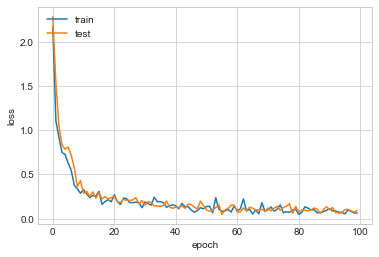

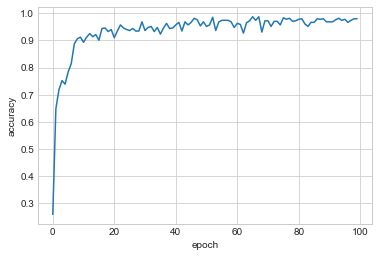

In [12]:
plt.plot(test_losses)
plt.plot(train_losses)

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(train_accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

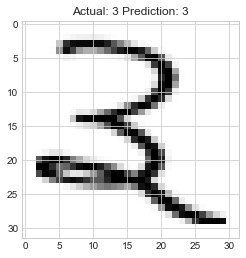

In [14]:
example = next(iter(testloader))

label = example[0][0]
image = th.reshape(example[0][1:].float(), (1, 1, 32, 32))
# image = image.view(image.shape[0], -1)
prediction = model(image)

pred_label = th.argmax(prediction)

title = f"Actual: {int(label)} Prediction: {pred_label}"

plt.imshow(image.reshape(32, 32))
plt.title(title)
plt.show()

In [15]:
th.save(model.state_dict(), 'dcrcnn.pth')

In [27]:
state_dict = th.load('dcrcnn.pth')


collections.OrderedDict

IncompatibleKeys(missing_keys=[], unexpected_keys=[])
